# Part 1: Nelder Mead

In [74]:
import numpy as np

np.random.seed(42) 
    
class Simplex:
    """ For generality """
    def __init__(self, vertices, mode=1):        
        self.vertices = np.array(vertices)
        self.n_dim = self.vertices[0].shape[0]  # Number of dimensions
        
        assert self.vertices.shape[0] == self.n_dim + 1, "Simplex must have n+1 vertices in n dimensions"
        
        self.mode = mode
        
    def __repr__(self):
        return f"Simplex(vertices={self.vertices})"
    
    def sort_simplex(self, func):
        vals = [func(vertex, i=self.mode) for vertex in self.vertices]
        sorted_vertices = np.array([self.vertices[i] for i in np.argsort(vals)])
        self.vertices = sorted_vertices
        return np.sort(vals)
            
    def centroid(self):
        centroid = np.mean(self.vertices[:-1], axis=0)  # Exclude the worst point      
        return centroid
    
    def converged(self, tol=1e-6):
        """ Check if the simplex has converged based on the tolerance. """
        return np.max(np.abs(self.vertices - np.mean(self.vertices, axis=0))) < tol

    def reflect(self, c, alpha):
        """Reflect worst point across the centriod - also used for extension and contraction"""
        x_w = self.vertices[-1]
        return c + alpha * (c - x_w)
    
    def contract(self, c, x_r, beta, mode="outside"):
        if mode == 'outside':
            return c + beta * (x_r - c)
        else:  # inside contraction
            return c - beta * (c - self.vertices[-1])
    
    def diameter(self):
        """Compute the maximum distance between any two vertices."""
        return np.max(np.linalg.norm(self.vertices - self.vertices[:, np.newaxis], axis=-1))
    
    def shrink(self, delta):
        self.vertices[1:] = self.vertices[0] + delta * (self.vertices[1:] - self.vertices[0])

 
    
alpha = 1.0  # Reflection
beta = 0.5 # Contraction
gamma = 2.0  # Expansion
delta = 0.5 # Shrinkage    

all_vertices = []
    
def nelder_mead(func, simplex: Simplex, max_iter=1000, tol=1e-10, verbose=False, mode=1):
    """
    Perform the Nelder-Mead optimization algorithm in 2D.

    Parameters:
    - func: The objective function to minimize.
    - simplex: A list of points defining the initial simplex.
    - max_iter: Maximum number of iterations.
    - tol: Tolerance for convergence.

    Returns:
    - The point that minimizes the function.
    """
    no_improve = 0
    prev_best = float("inf")
    prev_worst = float("inf")
    
    for k in range(max_iter):
        vals = simplex.sort_simplex(func)
        
        step_data = np.hstack([simplex.vertices, np.array(vals).reshape(-1,1)])
        all_vertices.append(step_data)
        
        f_best, f_mid, f_worst = vals[0], vals[1], vals[-1]

        diameter = simplex.diameter()
        if diameter < tol:
            print(f"Converged at iteration {k}.")
            break
        
        if abs(prev_best - f_best) < tol:
            no_improve += 1
            if no_improve > 10:
                print(f"No improvement for 10 iterations, stopping at iteration {k}.")
                break
            else:
                no_improve = 0
                prev_best = f_best
            
        
        if verbose:
            print(f"iter {k:3d}, diameter={diameter:.12f} ")
            print("Simplex vertices:\n", simplex.vertices)
            print("Function values:", f_best, f_mid, f_worst)
            print("Diff (worst):", prev_worst - f_worst)
            print("-----------------------\n")

        prev_worst = f_worst
        centroid = simplex.centroid()
        
        # Reflection & Extension
        reflected = simplex.reflect(centroid, alpha)
        reflected_value = func(reflected, mode)   # Dont recompute (can precompute for all vertices each iteration)
        
        
        if reflected_value < f_mid:
            if reflected_value < f_best: # Expand reflection if it was better than the second worst
                extended = simplex.reflect(centroid, gamma)  

                if func(extended, mode) < reflected_value:
                    simplex.vertices[-1] = extended
                    
                else:
                    simplex.vertices[-1] = reflected
            else:
                simplex.vertices[-1] = reflected
            
            continue

        # Contraction
        if reflected_value >= f_mid:
            # Outside contraction
            contracted = simplex.contract(centroid, reflected, beta, mode='outside')
            contracted_value = func(contracted, mode)
            
            if contracted_value < reflected_value:
                simplex.vertices[-1] = contracted
            else:
                # Shrink
                simplex.shrink(delta)
        
        else:
            # Inside contraction
            contracted = simplex.contract(centroid, reflected, beta, mode='inside')
            contracted_value = func(contracted, mode)
            
            if contracted_value < f_worst:
                simplex.vertices[-1] = contracted
            else:
                # Shrink
                simplex.shrink(delta)
            
    return simplex.vertices[0]

### Testing GD functions

The GD results were taken from the GD homework.

In [65]:
def f1(x, i=0):
    x, y, z = x
    return (x - z)**2 + (2*y + z)**2 + (4*x - 2*y + z)**2 + x + y

start_f1 = np.array([0,0,0], dtype=float)

In [66]:
def f2(x, i=0):
    x,y,z = x
    return (x - 1)**2 + (y - 1)**2 + 100*(y-x**2)**2 + 100*(z-y**2)**2

start_f2 = np.array([1.2, 1.2, 1.2], dtype=float)

In [67]:
def f3(x, i=0):
    x,y = x
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

start_f3 = np.array([1,1], dtype=float)

In [68]:
# x, y, (z) + f(x,y,(z)) # Approximate minimums of the functions
# f1 minimum: [-0.16232465 -0.22244489  0.16232465 -0.19775824]
# f2 minimum: [1.00400802 1.00400802 1.00400802 0.00327077]
# f3 minimum: [3.00000000e+00 5.00150015e-01 5.19139201e-07]

#### F1

In [100]:
import time

In [103]:
t0 = time.time()
for _ in range(10):
    simplex = Simplex([start_f1,
                    start_f1 + np.array([1, 0, 0], dtype=float),
                    start_f1 + np.array([0, 1, 0], dtype=float),
                    start_f1 + np.array([0, 0, 1], dtype=float)])

    min_pt = nelder_mead(f1, simplex, max_iter=100, tol=1e-5)

t_f3 = time.time() - t0 
t_f3 /= 10

print(t_f3 * 1000)

min_pt, f1(min_pt), simplex

Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
Converged at iteration 99.
7.700347900390625


(array([-0.16666641, -0.22917089,  0.16667391]),
 np.float64(-0.19791666633720859),
 Simplex(vertices=[[-0.16666641 -0.22917089  0.16667391]
  [-0.16666442 -0.2291687   0.16667315]
  [-0.16666897 -0.2291746   0.16667705]
  [-0.16666657 -0.22916979  0.16667868]]))

#### F2

In [102]:
t0 = time.time()
for _ in range(10):
    simplex = Simplex([start_f2,
                    start_f2 + np.array([1, 0, 0], dtype=float),
                    start_f2 + np.array([0, 1, 0], dtype=float),
                    start_f2 + np.array([0, 0, 1], dtype=float)])

    min_pt = nelder_mead(f2, simplex, max_iter=100, tol=1e-5)
    
t_f3 = time.time() - t0 
t_f3 /= 10

print(t_f3 * 1000)
min_pt, f2(min_pt)

6.9573163986206055


(array([0.99595354, 0.99150024, 0.98497188]),
 np.float64(0.0004672126732384441))

#### F3

In [101]:
t0 = time.time()
for _ in range(10):
    simplex = Simplex([start_f3,
                    start_f3 + np.array([1, 0], dtype=float),
                    start_f3 + np.array([0, 1], dtype=float)])

    min_pt = nelder_mead(f3, simplex, max_iter=100, tol=1e-5)
min_pt, f3(min_pt)
t_f3 = time.time() - t0 
t_f3 /= 10

print(t_f3 * 1000)

Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
Converged at iteration 69.
4.95142936706543


In [ ]:

# Test for higher dimensions
def fx(x, i=0):
    x,y,z,a,b,c,d = x
    return (x - 1)**2 + (y - 1)**2 + (z - 1)**2 + (a - 1)**2 + (b - 1)**2 + (c - 1)**2 + (d - 1)**2

start_fx = np.array([1, 1, 1, 1, 1, 1, 1], dtype=float)

t0 = time.time()
for _ in range(10):
    simplex = Simplex([start_fx,
                    start_fx + np.array([1, 0, 0, 0, 0, 0, 0], dtype=float),
                    start_fx + np.array([0, 1, 0, 0, 0, 0, 0], dtype=float),
                    start_fx + np.array([0, 0, 1, 0, 0, 0, 0], dtype=float),
                    start_fx + np.array([0, 0, 0, 1, 0, 0, 0], dtype=float),
                    start_fx + np.array([0, 0, 0, 0, 1, 0, 0], dtype=float),
                    start_fx + np.array([0, 0, 0, 0, 0, 1, 0], dtype=float),
                    start_fx + np.array([0, 0, 0, 0, 0, 0, 1], dtype=float)])
    min_pt = nelder_mead(fx, simplex, max_iter=1000, tol=1e-7)
time_f1 = time.time() - t0
time_f1 /= 10
print(time_f1 * 1000)
min_pt, fx(min_pt)

Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
Converged at iteration 187.
15.426063537597656


(array([1., 1., 1., 1., 1., 1., 1.]), np.float64(0.0))

### The code for the black box optimization is in the nelder_mead.py since it had to be run as a script using WSL (problems with running .exe)
The only difference is in the subprocess calling the function and some call optimizations

In [ ]:
v_f1[:, 3][:, -1]

array([9.64432934e+08, 3.11164388e+08, 5.47943600e+06, 4.68265681e+05,
       1.89049898e+05, 9.16647252e+05, 8.77257155e+04, 8.70026720e+04,
       4.84079160e+04, 3.32163143e+04, 1.21502778e+03, 3.29247331e+02,
       1.01992329e+02, 1.03440599e+01, 1.33804946e+01, 6.67061002e+00,
       4.14407649e+00, 1.23915987e+00, 1.22063070e+00, 1.09640438e+00,
       1.06042173e+00, 9.19391477e-01, 8.87189898e-01, 8.76033941e-01,
       8.30675386e-01, 8.04464890e-01, 7.89586145e-01, 7.23351228e-01,
       7.14673375e-01, 7.08255648e-01, 6.98872017e-01, 6.86220328e-01,
       6.81382823e-01, 6.67433062e-01, 6.60505589e-01, 6.42229618e-01,
       6.20670536e-01, 6.17091432e-01, 6.13256857e-01, 6.11201998e-01,
       6.10160810e-01, 6.09283674e-01, 6.07418855e-01, 6.04417213e-01,
       6.04393718e-01, 6.03503644e-01, 6.03424874e-01, 6.03346952e-01,
       6.03331828e-01, 6.03238915e-01, 6.03360320e-01, 6.03214936e-01,
       6.03163485e-01, 6.03091504e-01, 6.03073967e-01, 6.03081205e-01,
      

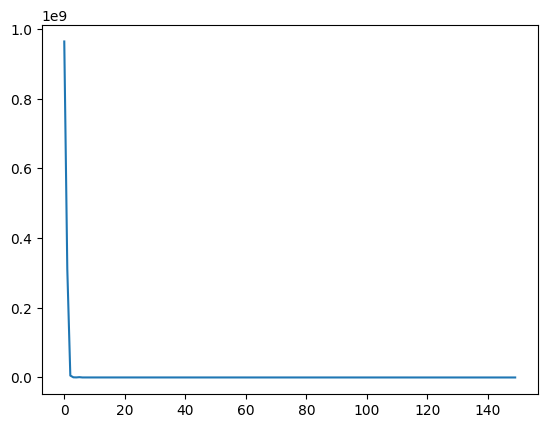

In [ ]:
plt.plot(v_f1[:, 3][:, -1])

## Jeklo ruse

In [ ]:
from itertools import combinations
import numpy as np

constraints = [
    (np.array([3, 1]), 600),   # C1: 3x1 + x2 = 600
    (np.array([2, 2]), 480),   # C2: 2x1 + 2x2 = 480
    (np.array([1, 0]), 0),     # C3: x1 = 0
    (np.array([0, 1]), 0)      # C4: x2 = 0
]

def is_feasible(x):
    x1, x2 = x
    return (
        3*x1 + x2 <= 600 + 1e-8 and     # C1
        2*x1 + 2*x2 <= 480 + 1e-8 and   # C2
        x1 >= -1e-8 and                 # Chack nonzero
        x2 >= -1e-8                     # Chack nonzero
    )

def objective(x1, x2):
    return 3*x1 + 2*x2

def jeklo_ruse():
    feasible_points = []

    # all combinations of 2 constraints
    for (A1, b1), (A2, b2) in combinations(constraints, 2):
        A = np.array([A1, A2])
        b = np.array([b1, b2])
        try:
            x = np.linalg.solve(A, b)
            if is_feasible(x):
                cost = objective(*x)
                feasible_points.append((x, cost))
        except np.linalg.LinAlgError:
            continue  # no intersection

    opt_point, opt_cost = max(feasible_points, key=lambda p: p[1])
    return opt_point, opt_cost 

In [ ]:
jeklo_ruse()

(array([180.,  60.]), np.float64(660.0))

Q: What if there are m variables and n constrains? How many candidate points do we get? \
A: we can get n over m candidate points, each point is a solution to a system of m equality constraints, but not all are feasible (some will violate some of the n-m constraints)